In [2]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import scipy.stats as stats
import scipy.ndimage as ndimage
import pymannkendall as mk

In [3]:
# importing data
# numpy array with columns of date/time and num_value

PC_0192_details = pd.read_csv("Details_PC-0192.csv", sep=',')
PC_0192_details

,Project ID,birth_deid_date,death_deid_date,sex,icu_visit,icu_start_deid_dttm,icu_end_deid_dttm,failed_extubation_flag,failed_extubation_deid_date,intubation_flag,extubation_flag,extubation_deid_date,extubation_score,re_intubation_deid_date,icu_ward
0,PC0192,22/06/2004,NaN,Male,1,22/12/2016 11:53,18/02/2017 17:13,1,10/01/2017 18:00,1,1,28/12/2016 18:00,5,11/01/2017 14:00,FLAMI


In [4]:
# changing required fields to correct datetime data type to avoid string issues

PC_0192_details['failed_extubation_deid_date'] = pd.to_datetime(PC_0192_details['failed_extubation_deid_date'], format='%d/%m/%Y %H:%M')
PC_0192_details['re_intubation_deid_date'] = pd.to_datetime(PC_0192_details['re_intubation_deid_date'], format='%d/%m/%Y %H:%M')


In [5]:
failed_extubation = PC_0192_details.iloc[0,8]
re_intubation = PC_0192_details.iloc[0,13]

print(failed_extubation, re_intubation)

2017-01-10 18:00:00 2017-01-11 14:00:00


In [6]:
PC_0192_ABF_data = pd.read_csv("PC0192/PC0192_1_ABF.csv", sep=',')
PC_0192_ABF_data['record_date_time'] = pd.to_datetime(PC_0192_ABF_data['record_date_time'], format='%Y-%m-%d %H:%M:%S')
PC_0192_ABF_data


,monitor,record_date_time,num_value
0,ARTd,2016-12-26 18:36:04,70
1,ARTm,2016-12-26 18:36:04,85
2,ARTs,2016-12-26 18:36:04,121
3,ARTd,2016-12-26 18:36:09,71
4,ARTm,2016-12-26 18:36:09,87
...,...,...,...
1392312,ABPs,2017-01-23 15:08:05,132
1392313,ABPd,2017-01-23 15:08:09,62
1392314,ABPm,2017-01-23 15:08:09,82
1392315,ABPs,2017-01-23 15:08:09,124


In [7]:
failed_extubation_index = PC_0192_ABF_data.record_date_time.searchsorted(failed_extubation)
re_intubation_index = PC_0192_ABF_data.record_date_time.searchsorted(re_intubation)

print(failed_extubation_index, re_intubation_index)

PC_0192_ABF_extubated = PC_0192_ABF_data.iloc[failed_extubation_index+1:re_intubation_index-1, :]
PC_0192_ABF_extubated

745630 788214


,monitor,record_date_time,num_value
745631,ABPm,2017-01-10 18:00:01,114
745632,ABPs,2017-01-10 18:00:01,123
745633,ABPd,2017-01-10 18:00:06,106
745634,ABPm,2017-01-10 18:00:06,115
745635,ABPs,2017-01-10 18:00:06,123
...,...,...,...
788208,ABPd,2017-01-11 13:59:52,66
788209,ABPm,2017-01-11 13:59:52,83
788210,ABPs,2017-01-11 13:59:52,118
788211,ABPd,2017-01-11 13:59:56,67


In [8]:
# separating out the systolic, diastolic and mean data points

PC_0192_ABF_s_extubated = pd.DataFrame(columns=['monitor','record_date_time','num_value'])
PC_0192_ABF_d_extubated = pd.DataFrame(columns=['monitor','record_date_time','num_value'])
PC_0192_ABF_m_extubated = pd.DataFrame(columns=['monitor','record_date_time','num_value'])

for idx in PC_0192_ABF_extubated.index:
    if PC_0192_ABF_extubated['monitor'].loc[idx] == 'ABPs':
        PC_0192_ABF_s_extubated = PC_0192_ABF_s_extubated.append(PC_0192_ABF_extubated.loc[idx])
    if PC_0192_ABF_extubated['monitor'].loc[idx] == 'ABPd':
        PC_0192_ABF_d_extubated = PC_0192_ABF_d_extubated.append(PC_0192_ABF_extubated.loc[idx])
    if PC_0192_ABF_extubated['monitor'].loc[idx] == 'ABPm':
        PC_0192_ABF_m_extubated = PC_0192_ABF_m_extubated.append(PC_0192_ABF_extubated.loc[idx])

In [9]:
print(PC_0192_ABF_s_extubated)
print(PC_0192_ABF_d_extubated)
print(PC_0192_ABF_m_extubated)


       monitor    record_date_time num_value
745632    ABPs 2017-01-10 18:00:01       123
745635    ABPs 2017-01-10 18:00:06       123
745638    ABPs 2017-01-10 18:00:11       124
745641    ABPs 2017-01-10 18:00:16       124
745644    ABPs 2017-01-10 18:00:21       124
...        ...                 ...       ...
788198    ABPs 2017-01-11 13:59:32       120
788201    ABPs 2017-01-11 13:59:36       119
788204    ABPs 2017-01-11 13:59:42       118
788207    ABPs 2017-01-11 13:59:46       117
788210    ABPs 2017-01-11 13:59:52       118

[14171 rows x 3 columns]
       monitor    record_date_time num_value
745633    ABPd 2017-01-10 18:00:06       106
745636    ABPd 2017-01-10 18:00:11       105
745639    ABPd 2017-01-10 18:00:16       106
745642    ABPd 2017-01-10 18:00:21       105
745645    ABPd 2017-01-10 18:00:26       107
...        ...                 ...       ...
788199    ABPd 2017-01-11 13:59:36        67
788202    ABPd 2017-01-11 13:59:42        66
788205    ABPd 2017-01-11 13:

### Using systolic data

In [10]:
# fixing data types

PC_0192_ABF_s_extubated['record_date_time'] = pd.to_datetime(PC_0192_ABF_s_extubated['record_date_time'], format='%Y-%m-%d %H:%M:%S')
PC_0192_ABF_s_extubated['num_value'] = pd.to_numeric(PC_0192_ABF_s_extubated['num_value'])

PC_0192_ABF_d_extubated['record_date_time'] = pd.to_datetime(PC_0192_ABF_d_extubated['record_date_time'], format='%Y-%m-%d %H:%M:%S')
PC_0192_ABF_d_extubated['num_value'] = pd.to_numeric(PC_0192_ABF_d_extubated['num_value'])

PC_0192_ABF_m_extubated['record_date_time'] = pd.to_datetime(PC_0192_ABF_m_extubated['record_date_time'], format='%Y-%m-%d %H:%M:%S')
PC_0192_ABF_m_extubated['num_value'] = pd.to_numeric(PC_0192_ABF_m_extubated['num_value'])


In [11]:
ndimage.gaussian_filter1d(PC_0192_ABF_s_extubated['num_value'],sigma=100)

array([135, 135, 135, ..., 132, 132, 132])

In [12]:
# smoothing and subtracting to obtain residuals

PC_0192_ABF_s_extubated_smoothed = PC_0192_ABF_s_extubated.copy()
PC_0192_ABF_s_residuals = PC_0192_ABF_s_extubated.copy()
PC_0192_ABF_s_extubated_smoothed['num_value'] = ndimage.gaussian_filter1d(PC_0192_ABF_s_extubated['num_value'], sigma=100)
PC_0192_ABF_s_residuals['num_value'] = PC_0192_ABF_s_extubated['num_value'] - PC_0192_ABF_s_extubated_smoothed['num_value']
PC_0192_ABF_s_residuals

,monitor,record_date_time,num_value
745632,ABPs,2017-01-10 18:00:01,-12
745635,ABPs,2017-01-10 18:00:06,-12
745638,ABPs,2017-01-10 18:00:11,-11
745641,ABPs,2017-01-10 18:00:16,-11
745644,ABPs,2017-01-10 18:00:21,-11
...,...,...,...
788198,ABPs,2017-01-11 13:59:32,-12
788201,ABPs,2017-01-11 13:59:36,-13
788204,ABPs,2017-01-11 13:59:42,-14
788207,ABPs,2017-01-11 13:59:46,-15


### Removing anomalies

In [13]:
mu_residual = PC_0192_ABF_s_residuals['num_value'].mean()
sigma_residual = PC_0192_ABF_s_residuals['num_value'].std()
median_residual = PC_0192_ABF_s_residuals['num_value'].median()

print(mu_residual, sigma_residual, median_residual)

0.4933314515559946 7.861917535882353 0.0


In [14]:
PC_0192_ABF_s_residuals_no_anomalies = PC_0192_ABF_s_residuals.copy()

for idx, val in enumerate(PC_0192_ABF_s_residuals_no_anomalies['num_value']):
    if not (mu_residual - 3*sigma_residual < val < mu_residual + 3*sigma_residual):
        if idx == 0:
            PC_0192_ABF_s_residuals_no_anomalies['num_value'].iloc[idx] = PC_0192_ABF_s_residuals['num_value'].iloc[idx+1]
        if idx == 14171:
            PC_0192_ABF_s_residuals_no_anomalies['num_value'].iloc[idx] = PC_0192_ABF_s_residuals['num_value'].iloc[idx-1]
        else:
            # PC_0192_ABF_s_residuals_no_anomalies['num_value'].iloc[idx] = 0.5*(PC_0192_ABF_s_residuals['num_value'].iloc[idx+2] + PC_0192_ABF_s_residuals['num_value'].iloc[idx-2])
            PC_0192_ABF_s_residuals_no_anomalies['num_value'].iloc[idx] = mu_residual
            print(idx)


1068
2597
2615
2631
2633
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2658
2659
2660
2662
2663
3514
3515
3516
3517
4956
4957
4958
4959
6761
6876
6975
7743
7744
9113
9114
9115
10536
10611
10612
10613
10614
10615
10616
10617
10618
10619
10620
10621
10622
10623
10624
10625
10626
10627
10628
10629
10630
10631
10636
10637
10638
10770
10772
10775
10796
10797
10798
10799
10800
10801
10802
10803
10804
10805
10806
10807
10808
10809
10810
10811
10812
10813
10814
10815
10816
10817
10818
10819
10820
10821
10822
10823
10824
10825
10827
10828
10857
10858
10859
10860
10861
10862
10863
10864
10865
10867
11403
11404
11405
11406
11407
11411
11412
11413
11415
11416
11418
11419
11420
11421
11423
11665
11666
11667
11668
11669
11670
11671
11672
11673
12960
12961
12962
13435
13436
13437
13438


/Users/lucindakhalil/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Multiple anomilies right next to each other

<AxesSubplot:xlabel='record_date_time'>

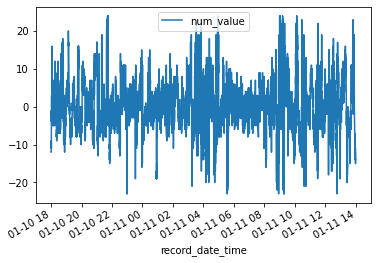

In [15]:
PC_0192_ABF_s_residuals_no_anomalies.plot(x='record_date_time', y='num_value')

### Functions

In [77]:
def rolling_mean(data, time):
    """
    Inputs:
    data - data frame of numerical values during the time the patient was exhastubated with columns 'record_date_time' and 'autocorrelation'
    time - size of window in minutes
    """
    global df
    global p

    k = 0

    df = pd.DataFrame(columns=['start_time','end_time','mean'])

    while (data['record_date_time'].iloc[0] + timedelta(minutes=time+k)) < data['record_date_time'].iloc[-1]:

        index_1 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=k))
        index_2 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=time+k))

        mean = data['num_value'][index_1:index_2].mean()

        df = df.append({'start_time': data['record_date_time'].iloc[index_1], 'end_time':data['record_date_time'].iloc[index_2], 'mean':mean}, ignore_index=True)
        k += 1

    for i, row in enumerate(df['mean']):
        if pd.isnull(row):
            df = df.drop(i)
    
    df['mean'] = pd.to_numeric(df['mean'])

    df.plot(x='start_time', y='mean', figsize=(10,8))

    p = mk.hamed_rao_modification_test(df['mean'])[2]

    print(f"The kendall tau correlation coefficient of the autocorrelation is {stats.kendalltau(df['start_time'], df['mean'])[0]}, and the p-value is {stats.kendalltau(df['start_time'], df['mean'])[1]}.")
    print(f"The Hamid and Rao correction relusts in a p-value of {mk.hamed_rao_modification_test(df['mean'])[2]}")
    print(f"Output of Hamid Rao correction: {mk.hamed_rao_modification_test(df['mean'])}")

In [78]:
def rolling_variance(data, time):
    """
    Inputs:
    data - data frame of numerical values during the time the patient was exhastubated with columns 'record_date_time' and 'variance'
    time - size of window in minutes
    """
    global df
    global p
    
    k = 0

    df = pd.DataFrame(columns=['start_time','end_time','variance'])

    while (data['record_date_time'].iloc[0] + timedelta(minutes=time+k)) < data['record_date_time'].iloc[-1]:

        index_1 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=k))
        index_2 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=time+k))

        var = data['num_value'][index_1:index_2].var()

        df = df.append({'start_time': data['record_date_time'].iloc[index_1], 'end_time':data['record_date_time'].iloc[index_2], 'variance':var}, ignore_index=True)
        k += 1

    for i, row in enumerate(df['variance']):
        if pd.isnull(row):
            df = df.drop(i)
    
    df['variance'] = pd.to_numeric(df['variance'])

    df.plot(x='start_time', y='variance', figsize=(10,8))

    mk.hamed_rao_modification_test(df['variance'])[2]

    print(f"The kendall tau correlation coefficient of the variance is {stats.kendalltau(df['start_time'], df['variance'])[0]}, and the p-value is {stats.kendalltau(df['start_time'], df['variance'])[1]}.")
    print(f"The Hamid and Rao correction relusts in a p-value of {mk.hamed_rao_modification_test(df['variance'])[2]}")
    print(f"Output of Hamid Rao correction: {mk.hamed_rao_modification_test(df['variance'])}")


In [79]:
def rolling_autocorrelation(data, time):
    """
    Inputs:
    data - data frame of numerical values during the time the patient was exhastubated with columns 'record_date_time' and 'autocorrelation'
    time - size of window in minutes
    """
    global df
    global p
    
    k = 0

    df = pd.DataFrame(columns=['start_time','end_time','autocorrelation'])

    while (data['record_date_time'].iloc[0] + timedelta(minutes=time+k)) < data['record_date_time'].iloc[-1]:

        index_1 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=k))
        index_2 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=time+k))

        ac = data['num_value'][index_1:index_2].autocorr()

        df = df.append({'start_time': data['record_date_time'].iloc[index_1], 'end_time':data['record_date_time'].iloc[index_2], 'autocorrelation':ac}, ignore_index=True)
        k += 1

    for i, row in enumerate(df['autocorrelation']):
        if pd.isnull(row):
            df = df.drop(i)
    
    df['autocorrelation'] = pd.to_numeric(df['autocorrelation'])

    df.plot(x='start_time', y='autocorrelation', figsize=(10,8))

    mk.hamed_rao_modification_test(df['autocorrelation'])[2]

    print(f"The kendall tau correlation coefficient of the autocorrelation is {stats.kendalltau(df['start_time'], df['autocorrelation'])[0]}, and the p-value is {stats.kendalltau(df['start_time'], df['autocorrelation'])[1]}.")
    print(f"The Hamid and Rao correction relusts in a p-value of {mk.hamed_rao_modification_test(df['autocorrelation'])[2]}")
    print(f"Output of Hamid Rao correction: {mk.hamed_rao_modification_test(df['autocorrelation'])}")


The kendall tau correlation coefficient of the autocorrelation is 0.5575955201811101, and the p-value is 6.50417566765818e-175.
The Hamid and Rao correction relusts in a p-value of 0.0
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.0, z=8.66007234835999, Tau=0.5575928407498113, s=362006.0, var_s=1747374918.3483162, slope=0.02042201599404456, intercept=134.51302054423303)


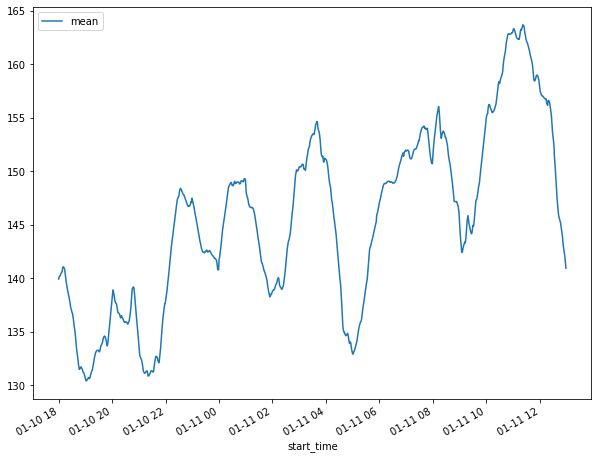

In [19]:
rolling_mean(PC_0192_ABF_s_extubated, 60)

The kendall tau correlation coefficient of the variance is 0.10476912946617989, and the p-value is 1.1710019291450283e-07.
The Hamid and Rao correction relusts in a p-value of 0.06280095534009211
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.06280095534009211, z=1.86059808597967, Tau=0.10477026631548142, s=68020.0, var_s=1336458094.6531842, slope=0.020040178762799014, intercept=64.79522865443894)


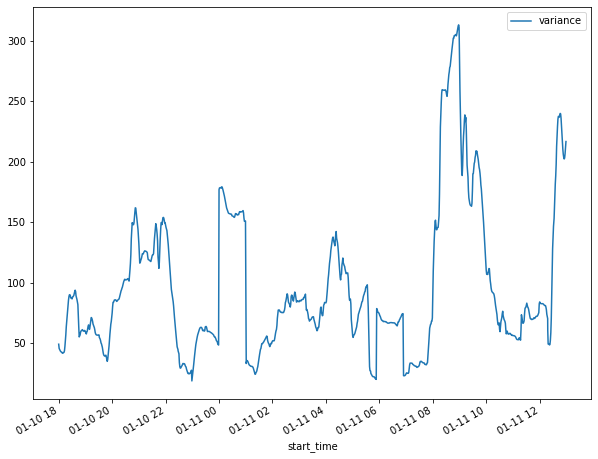

In [20]:
rolling_variance(PC_0192_ABF_s_extubated, 60)

The kendall tau correlation coefficient of the autocorrelation is -0.15623336965971407, and the p-value is 2.779896770846414e-15.
The Hamid and Rao correction relusts in a p-value of 0.07985256631618198
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.07985256631618198, z=-1.751542156605486, Tau=-0.1562312277621182, s=-101430.0, var_s=3353382537.867046, slope=-2.2579022691866495e-05, intercept=0.9741647791420511)


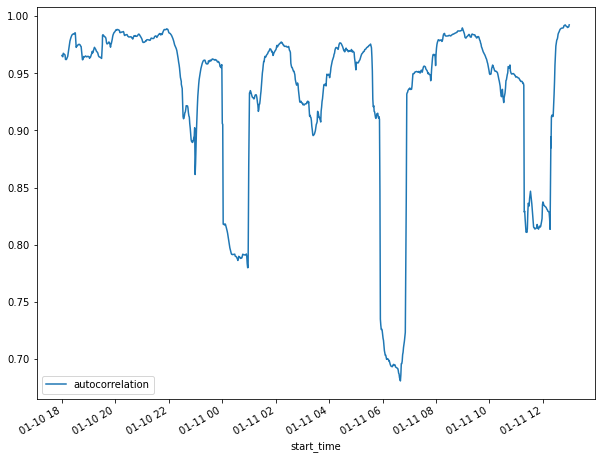

In [21]:
rolling_autocorrelation(PC_0192_ABF_s_extubated, 60)

The kendall tau correlation coefficient of the autocorrelation is 0.07966161875068382, and the p-value is 5.62028183423639e-05.
The Hamid and Rao correction relusts in a p-value of 0.08766587219222455
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.08766587219222455, z=1.7078408758793728, Tau=0.07966052092478783, s=51718.0, var_s=917005290.0624964, slope=0.00023283746134838696, intercept=0.2729384714468482)


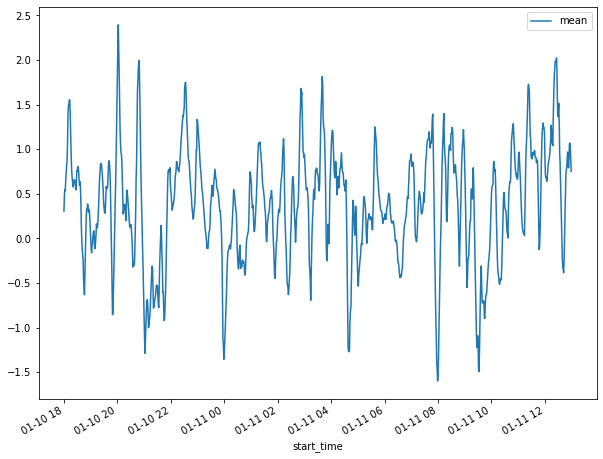

In [22]:
rolling_mean(PC_0192_ABF_s_residuals_no_anomalies, 60)

The kendall tau correlation coefficient of the variance is 0.1236993195768747, and the p-value is 3.9693766192557554e-10.
The Hamid and Rao correction relusts in a p-value of 0.2008443031232603
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.2008443031232603, z=1.2791498184031178, Tau=0.12369730295888977, s=80308.0, var_s=3941522207.472642, slope=0.014492180680521983, intercept=30.31405318735161)


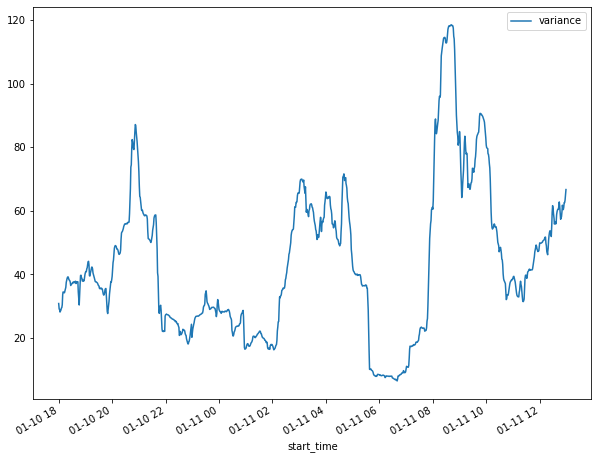

In [23]:
rolling_variance(PC_0192_ABF_s_residuals_no_anomalies, 60)

The kendall tau correlation coefficient of the autocorrelation is -0.16408577886917883, and the p-value is 1.0633435824403853e-16.
The Hamid and Rao correction relusts in a p-value of 0.18351425606270588
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.18351425606270588, z=-1.3300121867103722, Tau=-0.1640836067341312, s=-106528.0, var_s=6415169749.41343, slope=-2.9149763137718425e-05, intercept=0.9314541274682532)


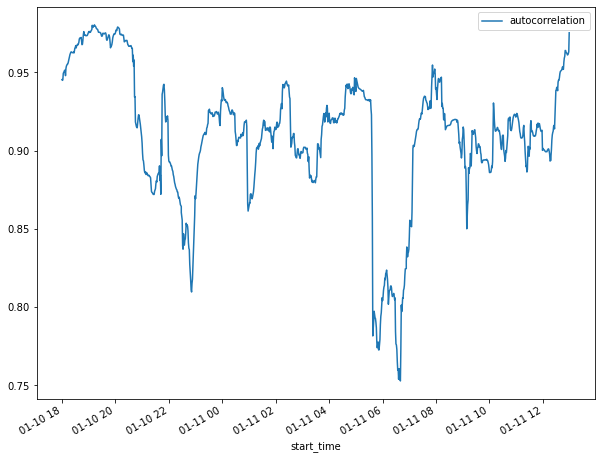

In [24]:
rolling_autocorrelation(PC_0192_ABF_s_residuals_no_anomalies, 60)

### Using mean (rather than systolic)

In [25]:
# smoothing and subtracting to obtain residuals

PC_0192_ABF_m_extubated_smoothed = PC_0192_ABF_m_extubated.copy()
PC_0192_ABF_m_residuals = PC_0192_ABF_m_extubated.copy()
PC_0192_ABF_m_extubated_smoothed['num_value'] = ndimage.gaussian_filter1d(PC_0192_ABF_m_extubated['num_value'], sigma=100)
PC_0192_ABF_m_residuals['num_value'] = PC_0192_ABF_m_extubated['num_value'] - PC_0192_ABF_m_extubated_smoothed['num_value']
PC_0192_ABF_m_residuals

,monitor,record_date_time,num_value
745631,ABPm,2017-01-10 18:00:01,-6
745634,ABPm,2017-01-10 18:00:06,-5
745637,ABPm,2017-01-10 18:00:11,-5
745640,ABPm,2017-01-10 18:00:16,-4
745643,ABPm,2017-01-10 18:00:21,-5
...,...,...,...
788200,ABPm,2017-01-11 13:59:36,-9
788203,ABPm,2017-01-11 13:59:42,-10
788206,ABPm,2017-01-11 13:59:46,-10
788209,ABPm,2017-01-11 13:59:52,-10


In [26]:
mu_residual_m = PC_0192_ABF_m_residuals['num_value'].mean()
sigma_residual_m = PC_0192_ABF_m_residuals['num_value'].std()

In [27]:
PC_0192_ABF_m_residuals_no_anomalies = PC_0192_ABF_m_residuals.copy()

for idx, val in enumerate(PC_0192_ABF_m_residuals_no_anomalies['num_value']):
    if not (mu_residual_m - 3*sigma_residual_m < val < mu_residual_m + 3*sigma_residual_m):
        if idx == 0:
            PC_0192_ABF_m_residuals_no_anomalies['num_value'].iloc[idx] = PC_0192_ABF_m_residuals['num_value'].iloc[idx+1]
        if idx == 14240:
            PC_0192_ABF_m_residuals_no_anomalies['num_value'].iloc[idx] = PC_0192_ABF_m_residuals['num_value'].iloc[idx-1]
        else:
            # PC_0192_ABF_m_residuals_no_anomalies['num_value'].iloc[idx] = 0.5*(PC_0192_ABF_m_residuals['num_value'].iloc[idx+1] + PC_0192_ABF_m_residuals['num_value'].iloc[idx-1])
            PC_0192_ABF_m_residuals_no_anomalies['num_value'].iloc[idx] = mu_residual_m


/Users/lucindakhalil/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:xlabel='record_date_time'>

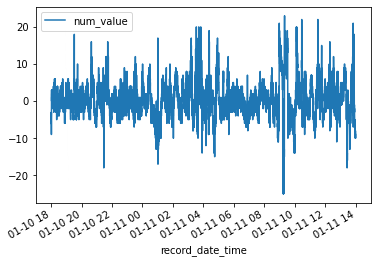

In [28]:
PC_0192_ABF_m_residuals_no_anomalies.plot(x='record_date_time', y='num_value')

The kendall tau correlation coefficient of the autocorrelation is 0.18076125079905256, and the p-value is 6.208164462366372e-20.
The Hamid and Rao correction relusts in a p-value of 0.1847263259381522
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.1847263259381522, z=1.3263423473532183, Tau=0.18075720468863116, s=117353.0, var_s=7828340712.957026, slope=0.006319566362004889, intercept=112.23836491138367)


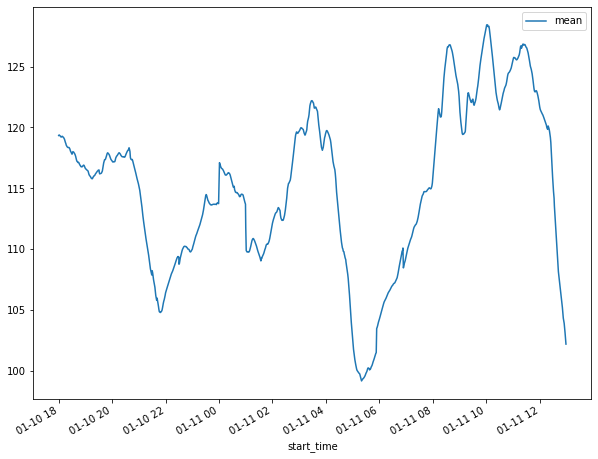

In [29]:
rolling_mean(PC_0192_ABF_m_extubated, 60)

The kendall tau correlation coefficient of the variance is 0.2194188948889031, and the p-value is 1.3178504941349464e-28.
The Hamid and Rao correction relusts in a p-value of 3.38557178474197e-05
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=3.38557178474197e-05, z=4.14584880783972, Tau=0.21941376707792307, s=142450.0, var_s=1180570398.3728704, slope=0.04388448172253902, intercept=29.379395931748093)


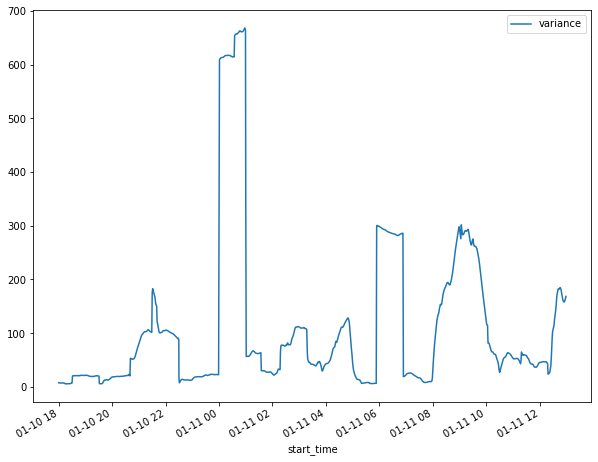

In [30]:
rolling_variance(PC_0192_ABF_m_extubated, 60)

The kendall tau correlation coefficient of the autocorrelation is 0.2954475966481939, and the p-value is 1.8038695900737792e-50.
The Hamid and Rao correction relusts in a p-value of 0.0
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.0, z=9.891231756913715, Tau=0.2954484543228132, s=191814.0, var_s=376058422.77135664, slope=9.197813899384553e-05, intercept=0.8582302536494486)


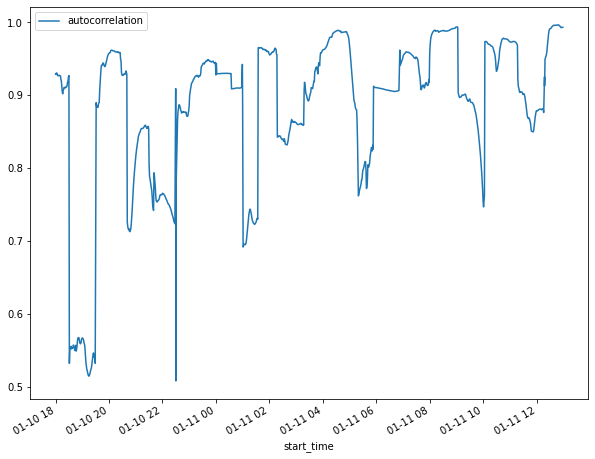

In [31]:
rolling_autocorrelation(PC_0192_ABF_m_extubated, 60)

The kendall tau correlation coefficient of the autocorrelation is 0.11626760667059396, and the p-value is 4.125026546441659e-09.
The Hamid and Rao correction relusts in a p-value of 0.11626021649535412
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.11626021649535412, z=1.5706661469990018, Tau=0.1162623415430587, s=75481.0, var_s=2309383275.0087376, slope=0.00036038699988560593, intercept=0.2425091182088366)


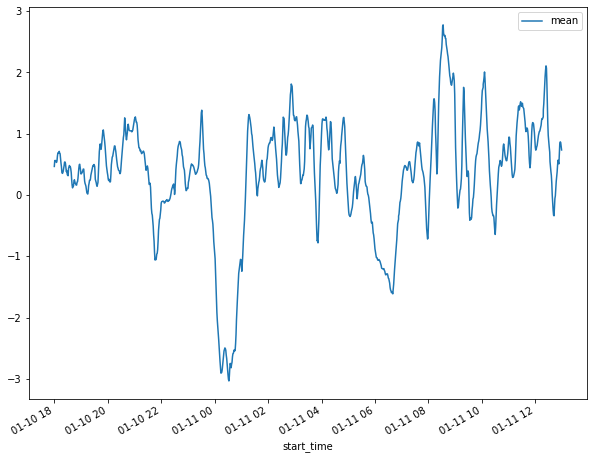

In [32]:
rolling_mean(PC_0192_ABF_m_residuals_no_anomalies, 60)

The kendall tau correlation coefficient of the variance is 0.29616229108936715, and the p-value is 1.0480547481371957e-50.
The Hamid and Rao correction relusts in a p-value of 0.0006729417825439565
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.0006729417825439565, z=3.400372226419427, Tau=0.29616314711273356, s=192278.0, var_s=3197435218.937686, slope=0.015967759793674312, intercept=5.220162852755919)


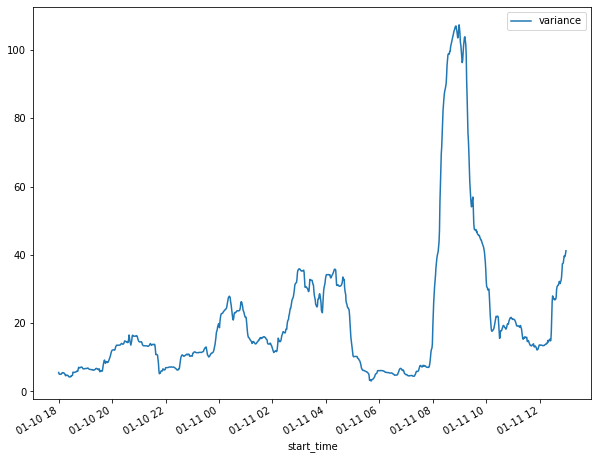

In [33]:
rolling_variance(PC_0192_ABF_m_residuals_no_anomalies, 60)

The kendall tau correlation coefficient of the autocorrelation is 0.16171347992313986, and the p-value is 2.896977934633621e-16.
The Hamid and Rao correction relusts in a p-value of 0.02283503165407419
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.02283503165407419, z=2.2761834565355565, Tau=0.16171156600896447, s=104988.0, var_s=2127436111.813037, slope=4.068222798748225e-05, intercept=0.8730971609918635)


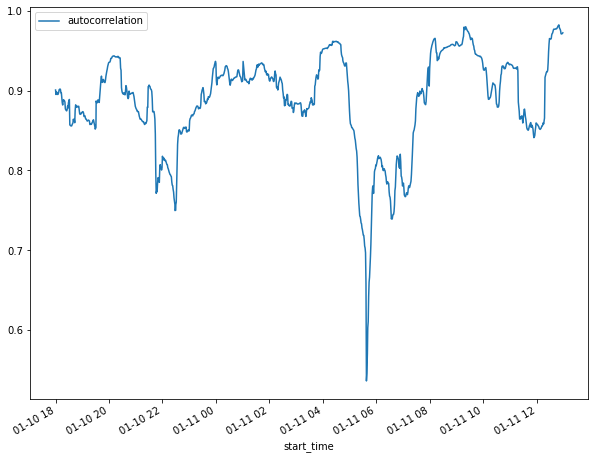

In [34]:
rolling_autocorrelation(PC_0192_ABF_m_residuals_no_anomalies, 60)

### Using diastolic:

In [35]:
# smoothing and subtracting to obtain residuals

PC_0192_ABF_d_extubated_smoothed = PC_0192_ABF_d_extubated.copy()
PC_0192_ABF_d_residuals = PC_0192_ABF_d_extubated.copy()
PC_0192_ABF_d_extubated_smoothed['num_value'] = ndimage.gaussian_filter1d(PC_0192_ABF_d_extubated['num_value'], sigma=100)
PC_0192_ABF_d_residuals['num_value'] = PC_0192_ABF_d_extubated['num_value'] - PC_0192_ABF_d_extubated_smoothed['num_value']
PC_0192_ABF_d_residuals

,monitor,record_date_time,num_value
745633,ABPd,2017-01-10 18:00:06,-2
745636,ABPd,2017-01-10 18:00:11,-3
745639,ABPd,2017-01-10 18:00:16,-2
745642,ABPd,2017-01-10 18:00:21,-3
745645,ABPd,2017-01-10 18:00:26,-1
...,...,...,...
788199,ABPd,2017-01-11 13:59:36,-8
788202,ABPd,2017-01-11 13:59:42,-9
788205,ABPd,2017-01-11 13:59:46,-9
788208,ABPd,2017-01-11 13:59:52,-9


In [36]:
mu_residual_d = PC_0192_ABF_d_residuals['num_value'].mean()
sigma_residual_d = PC_0192_ABF_d_residuals['num_value'].std()

In [37]:
PC_0192_ABF_m_residuals_no_anomalies = PC_0192_ABF_m_residuals.copy()

for idx, val in enumerate(PC_0192_ABF_m_residuals_no_anomalies['num_value']):
    if not (mu_residual_m - 3*sigma_residual_m < val < mu_residual_m + 3*sigma_residual_m):
        if idx == 0:
            PC_0192_ABF_m_residuals_no_anomalies['num_value'].iloc[idx] = PC_0192_ABF_m_residuals['num_value'].iloc[idx+1]
        if idx == 14240:
            PC_0192_ABF_m_residuals_no_anomalies['num_value'].iloc[idx] = PC_0192_ABF_m_residuals['num_value'].iloc[idx-1]
        else:
            # PC_0192_ABF_m_residuals_no_anomalies['num_value'].iloc[idx] = 0.5*(PC_0192_ABF_m_residuals['num_value'].iloc[idx+1] + PC_0192_ABF_m_residuals['num_value'].iloc[idx-1])
            PC_0192_ABF_m_residuals_no_anomalies['num_value'].iloc[idx] = mu_residual_m


/Users/lucindakhalil/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [38]:
PC_0192_ABF_d_residuals_no_anomalies = PC_0192_ABF_d_residuals.copy()

for idx, val in enumerate(PC_0192_ABF_d_residuals_no_anomalies['num_value']):
    if not (mu_residual_d - 3*sigma_residual_d < val < mu_residual_d + 3*sigma_residual_d):
        if idx == 0:
            PC_0192_ABF_d_residuals_no_anomalies['num_value'].iloc[idx] = PC_0192_ABF_d_residuals['num_value'].iloc[idx+1]
        if idx == 14240:
            PC_0192_ABF_d_residuals_no_anomalies['num_value'].iloc[idx] = PC_0192_ABF_d_residuals['num_value'].iloc[idx-1]
        else:
            # PC_0192_ABF_m_residuals_no_anomalies['num_value'].iloc[idx] = 0.5*(PC_0192_ABF_m_residuals['num_value'].iloc[idx+1] + PC_0192_ABF_m_residuals['num_value'].iloc[idx-1])
            PC_0192_ABF_d_residuals_no_anomalies['num_value'].iloc[idx] = mu_residual_d


<AxesSubplot:xlabel='record_date_time'>

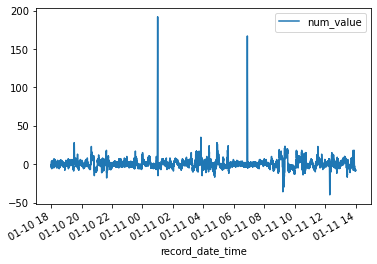

In [39]:
PC_0192_ABF_d_residuals.plot(x='record_date_time', y='num_value')

The kendall tau correlation coefficient of the autocorrelation is 0.013070526203838867, and the p-value is 0.5086810919695105.
The Hamid and Rao correction relusts in a p-value of 0.9297781819358861
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.9297781819358861, z=0.08812392376143681, Tau=0.013069328281194646, s=8485.0, var_s=9268589917.460201, slope=0.0004949607298166821, intercept=98.58339764214718)


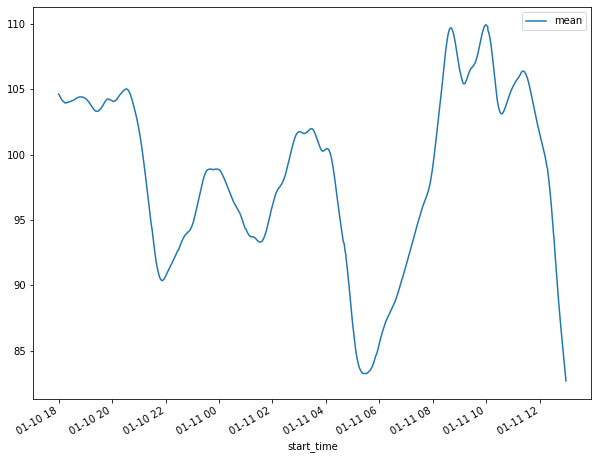

In [40]:
rolling_mean(PC_0192_ABF_d_extubated_smoothed, 60)

The kendall tau correlation coefficient of the variance is 0.3571588652035442, and the p-value is 6.489699457748047e-73.
The Hamid and Rao correction relusts in a p-value of 0.0003255166654880792
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.0003255166654880792, z=3.5940985136185906, Tau=0.35716002033177763, s=231879.0, var_s=4162355193.9306335, slope=0.011873732883405508, intercept=-0.6978200698451165)


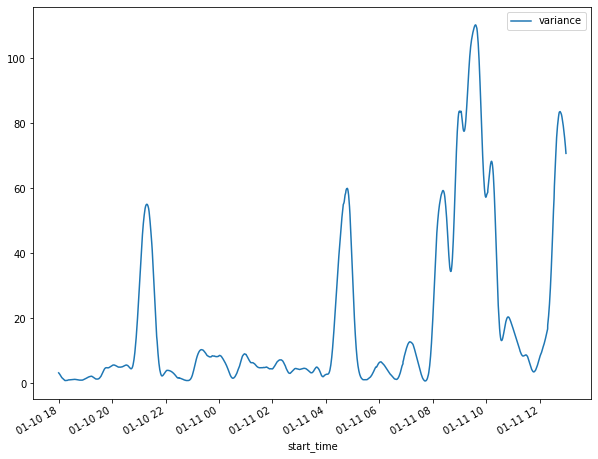

In [41]:
rolling_variance(PC_0192_ABF_d_extubated_smoothed, 60)

The kendall tau correlation coefficient of the autocorrelation is 0.15959262385555095, and the p-value is 7.013369928384466e-16.
The Hamid and Rao correction relusts in a p-value of 0.025554874093792312
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.025554874093792312, z=2.2329100896386067, Tau=0.15959829336290682, s=103616.0, var_s=2153291323.3647385, slope=3.011184361616847e-05, intercept=0.9281327964420438)


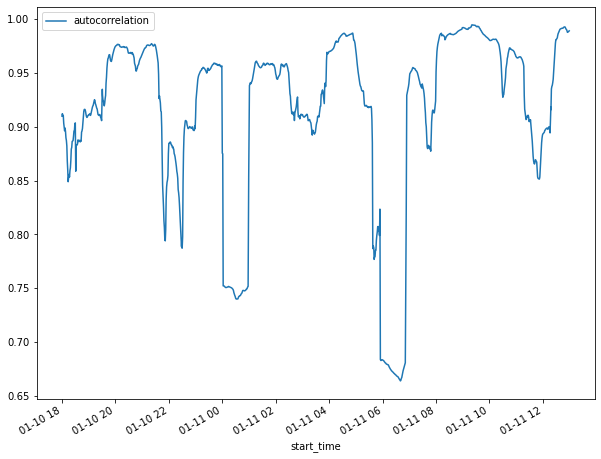

In [42]:
rolling_autocorrelation(PC_0192_ABF_d_extubated, 60)

The kendall tau correlation coefficient of the autocorrelation is 0.07282456674195845, and the p-value is 0.00023099416198729225.
The Hamid and Rao correction relusts in a p-value of 0.4454665756597689
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.4454665756597689, z=0.7629946681836426, Tau=0.07282165026261879, s=47278.0, var_s=3839342127.6793118, slope=0.00019080814068688355, intercept=0.25398298522269336)


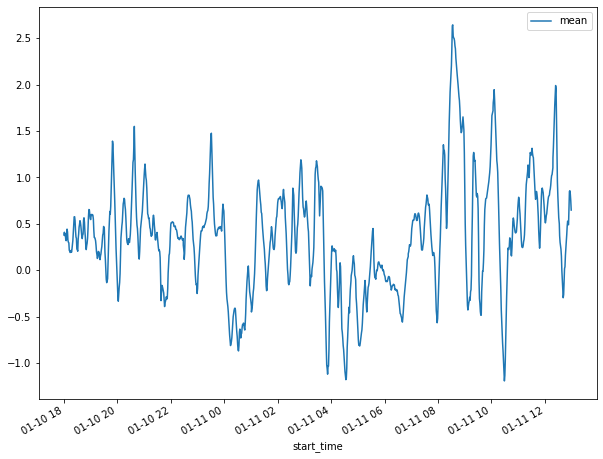

In [43]:
rolling_mean(PC_0192_ABF_d_residuals_no_anomalies, 60)

The kendall tau correlation coefficient of the variance is 0.1882868486013397, and the p-value is 1.7104353433966565e-21.
The Hamid and Rao correction relusts in a p-value of 0.012967908750023183
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.012967908750023183, z=2.484649381872118, Tau=0.1882892041341281, s=122243.0, var_s=2420531108.8103437, slope=0.009774693805232836, intercept=10.852158623232969)


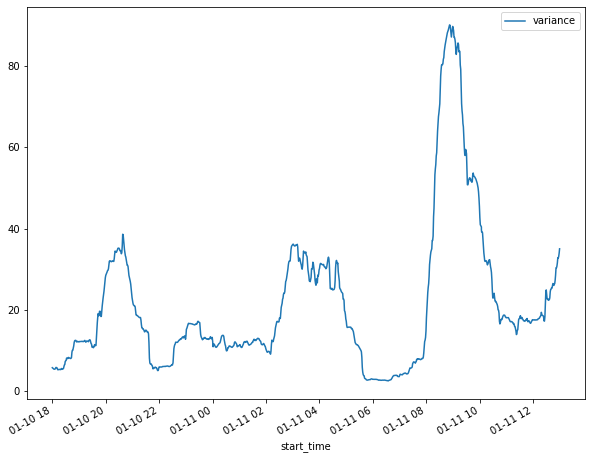

In [44]:
rolling_variance(PC_0192_ABF_d_residuals_no_anomalies, 60)

The kendall tau correlation coefficient of the autocorrelation is 0.04880257783113226, and the p-value is 0.013592702066206866.
The Hamid and Rao correction relusts in a p-value of 0.62981763655485
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.62981763655485, z=0.48198354371389857, Tau=0.04880550806339818, s=31686.0, var_s=4321584428.811379, slope=9.627655567123893e-06, intercept=0.8887805842555012)


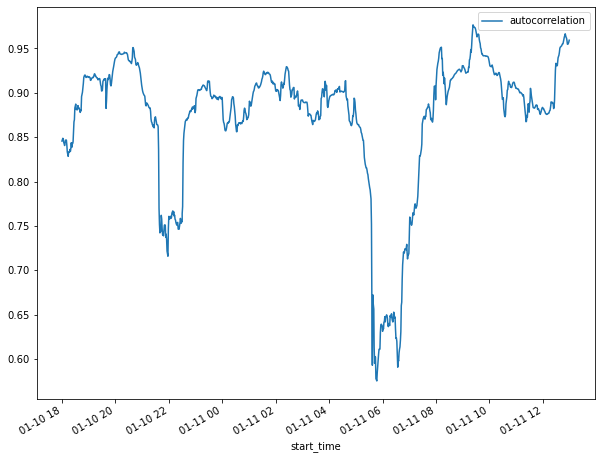

In [45]:
rolling_autocorrelation(PC_0192_ABF_d_residuals_no_anomalies, 60)

In [46]:
# def graph_grid(f, data, a, b, c, d, type_of_func):
#     """
#     Inputs:
#     f: function i.e rolling_mean or rolling_variance
#     data: 
#     a, b, c, d: 4 options for length of time windows in minutes
#     type_of_funct = mean, var or ac
#     units = 
#     """

#     time = [a, b, c, d]

#     # if type_of_func == 'mean':
#     #     y_lab = "Mean (BPM)"
#     #     typ = "mean"
#     # if type_of_func == 'variance':
#     #     y_lab = "Variance (BPM^2)"
#     #     typ = "variance"
#     # if type_of_func == 'autocorrelation':
#     #     y_lab = "Autocorrelation"
#     #     typ = "autocorrelation"

#     mean_df_list = []
#     rolling_mean(data, time[0])
#     mean_df_list.append(df)
#     rolling_mean(data, time[1])
#     mean_df_list.append(df)
#     rolling_mean(data, time[2])
#     mean_df_list.append(df)
#     rolling_mean(data, time[3])
#     mean_df_list.append(df)

#     var_df_list = []
#     rolling_variance(data, time[0])
#     var_df_list.append(df)
#     rolling_variance(data, time[1])
#     var_df_list.append(df)
#     rolling_variance(data, time[2])
#     var_df_list.append(df)
#     rolling_variance(data, time[3])
#     var_df_list.append(df)

#     ac_df_list = []
#     rolling_autocorrelation(data, time[0])
#     ac_df_list.append(df)
#     rolling_autocorrelation(data, time[1])
#     ac_df_list.append(df)
#     rolling_autocorrelation(data, time[2])
#     ac_df_list.append(df)
#     rolling_autocorrelation(data, time[3])
#     ac_df_list.append(df)

#     # fig, axs = plt.subplots(2, 2, figsize=(20,16))
    
#     # axs[0, 0].plot(df['start_time'], df[typ])
#     # axs[0, 0].set_title('30 minutes')

#     # f(data, time[1])
#     # axs[0, 1].plot(df['start_time'], df[typ], 'tab:orange')
#     # axs[0, 1].set_title('60 minutes')

#     # f(data, time[2])
#     # axs[1, 0].plot(df['start_time'], df[typ], 'tab:green')
#     # axs[1, 0].set_title('90 minutes')

#     # f(data, time[3])
#     # axs[1, 1].plot(df['start_time'], df[typ], 'tab:red')
#     # axs[1, 1].set_title('120 minutes')

#     fig, axs = plt.subplots(1, 3, figsize=(32,8), sharex=True,sharey=False)

#     plt.rcParams['font.size'] = '16'
#     fig.autofmt_xdate()

#     # axs[0, 0].cla()
#     axs[0].plot(mean_df_list[0]['start_time'], mean_df_list[0]['mean'], 'tab:blue', label="30 minutes")
#     # f(data, time[1])
#     axs[0].plot(mean_df_list[1]['start_time'], mean_df_list[1]['mean'], 'tab:orange', label="60 minutes")
#     # f(data, time[2])
#     axs[0].plot(mean_df_list[2]['start_time'], mean_df_list[2]['mean'], 'tab:green', label="90 minutes")
#     # f(data, time[3])
#     axs[0].plot(mean_df_list[3]['start_time'], mean_df_list[3]['mean'], 'tab:red', label="120 minutes")
#     # axs[0].legend()
#     axs[0].set(xlabel='Time (day-month hour)', ylabel="Mean (mmHg)")

#     axs[1].plot(var_df_list[0]['start_time'], var_df_list[0]['variance'], 'tab:blue', label="30 minutes")
#     # f(data, time[1])
#     axs[1].plot(var_df_list[1]['start_time'], var_df_list[1]['variance'], 'tab:orange', label="60 minutes")
#     # f(data, time[2])
#     axs[1].plot(var_df_list[2]['start_time'], var_df_list[2]['variance'], 'tab:green', label="90 minutes")
#     # f(data, time[3])
#     axs[1].plot(var_df_list[3]['start_time'], var_df_list[3]['variance'], 'tab:red', label="120 minutes")
#     # axs[1].legend()
#     axs[1].set(xlabel='Time (day-month hour)', ylabel="Variance (mmHg^2)")

#     axs[2].plot(ac_df_list[0]['start_time'], ac_df_list[0]['autocorrelation'], 'tab:blue', label="30 minutes")
#     # f(data, time[1])
#     axs[2].plot(ac_df_list[1]['start_time'], ac_df_list[1]['autocorrelation'], 'tab:orange', label="60 minutes")
#     # f(data, time[2])
#     axs[2].plot(ac_df_list[2]['start_time'], ac_df_list[2]['autocorrelation'], 'tab:green', label="90 minutes")
#     # f(data, time[3])
#     axs[2].plot(ac_df_list[3]['start_time'], ac_df_list[3]['autocorrelation'], 'tab:red', label="120 minutes")
#     # axs[2].legend()
#     axs[2].set(xlabel='Time (day-month hour)', ylabel="Autocorrelation")

In [47]:
# graph_grid(rolling_mean, PC_0192_ABF_m_residuals_no_anomalies, 30, 60, 90, 120, "mean")

The kendall tau correlation coefficient of the autocorrelation is 0.3156051595608857, and the p-value is 1.5362789206290943e-48.
The Hamid and Rao correction relusts in a p-value of 0.018372497252081565
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.018372497252081565, z=2.3580241585532398, Tau=0.31559567257559956, s=145275.0, var_s=3795589956.632171, slope=0.0006913573008875682, intercept=0.02951199653456138)


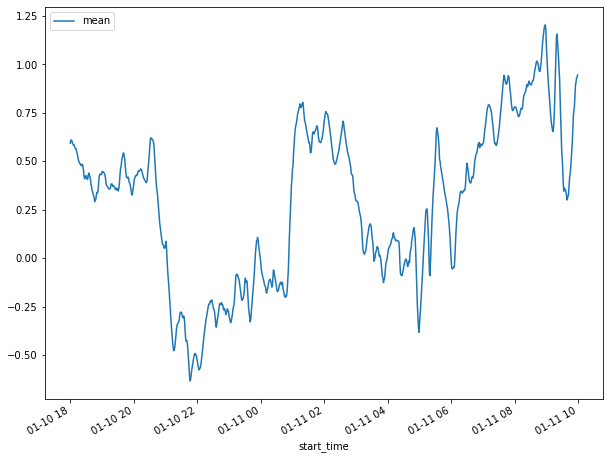

In [48]:
rolling_mean(PC_0192_ABF_m_residuals_no_anomalies, 240)

The kendall tau correlation coefficient of the autocorrelation is 0.258070550760863, and the p-value is 5.839364730187432e-37.
The Hamid and Rao correction relusts in a p-value of 0.0009535594184837404
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.0009535594184837404, z=3.303882051251048, Tau=0.2580716026499159, s=150368.0, var_s=2071361982.793576, slope=4.585925788378758e-05, intercept=0.8811533586071573)


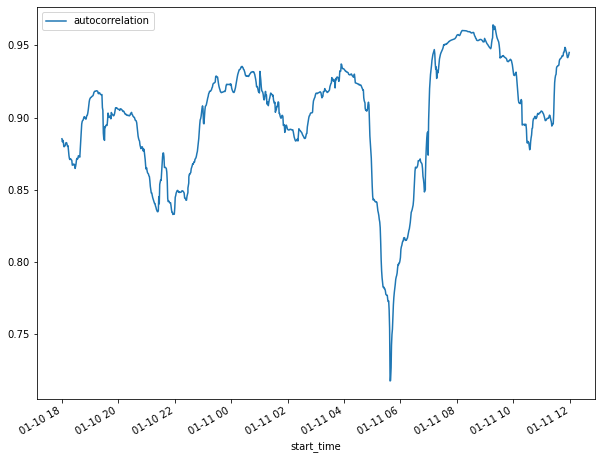

In [65]:
rolling_autocorrelation(PC_0192_ABF_m_residuals_no_anomalies, 120)

In [85]:
def graph_grid2(data, t, p_of_mean = False):
    """
    Inputs:

    """
    global p_list

    # time = [a, b, c, d]

    # if type_of_func == 'mean':
    #     y_lab = "Mean (BPM)"
    #     typ = "mean"
    # if type_of_func == 'variance':
    #     y_lab = "Variance (BPM^2)"
    #     typ = "variance"
    # if type_of_func == 'autocorrelation':
    #     y_lab = "Autocorrelation"
    #     typ = "autocorrelation"

    p_list = []
    rolling_mean(data, t)
    mean_df = df
    if p_of_mean:
        p_list.append(p)

    rolling_variance(data, t)
    var_df = df
    p_list.append(p)

    rolling_autocorrelation(data, t)
    ac_df = df
    p_list.append(p)

    fig, axs = plt.subplots(3, 1, figsize=(12, 24), sharex=False,sharey=False)

    plt.rcParams['font.size'] = '22'
    fig.autofmt_xdate()

    axs[0].plot(mean_df['start_time'], mean_df['mean'], 'tab:orange')
    axs[0].set(xlabel='Time (day-month hour)', ylabel="Mean (mmHg)")
    axs[0].set_title("Mean Blood Pressure (mmhg)", fontsize=30)

    axs[1].plot(var_df['start_time'], var_df['variance'], 'tab:green', label=f"p={p_list[0]}")
    axs[1].legend()
    axs[1].set(xlabel='Time (day-month hour)', ylabel="Variance (mmHg^2)")

    axs[2].plot(ac_df['start_time'], ac_df['autocorrelation'], 'tab:red', label=f"p={p_list[1]}")
    axs[2].legend()
    axs[2].set(xlabel='Time (day-month hour)', ylabel="Autocorrelation", ylim=[-1,1])

The kendall tau correlation coefficient of the autocorrelation is 0.11626760667059396, and the p-value is 4.125026546441659e-09.
The Hamid and Rao correction relusts in a p-value of 0.11626021649535412
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.11626021649535412, z=1.5706661469990018, Tau=0.1162623415430587, s=75481.0, var_s=2309383275.0087376, slope=0.00036038699988560593, intercept=0.2425091182088366)
The kendall tau correlation coefficient of the variance is 0.29616229108936715, and the p-value is 1.0480547481371957e-50.
The Hamid and Rao correction relusts in a p-value of 0.0006729417825439565
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.0006729417825439565, z=3.400372226419427, Tau=0.29616314711273356, s=192278.0, var_s=3197435218.937686, slope=0.015967759793674312, intercept=5.220162852755919)
The kendall tau correlation coefficient of the autocorrela

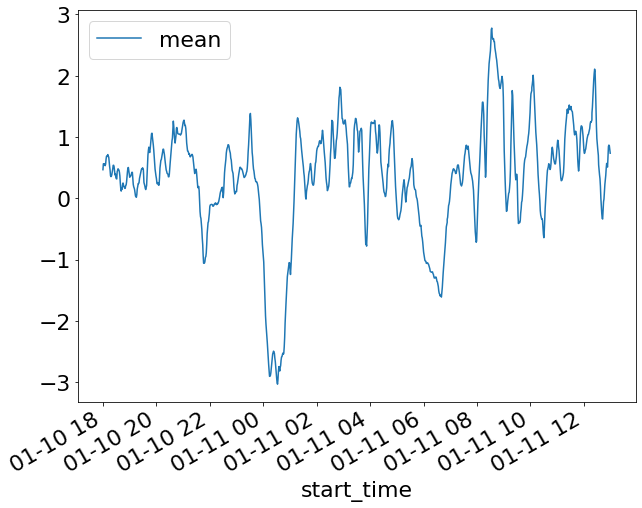

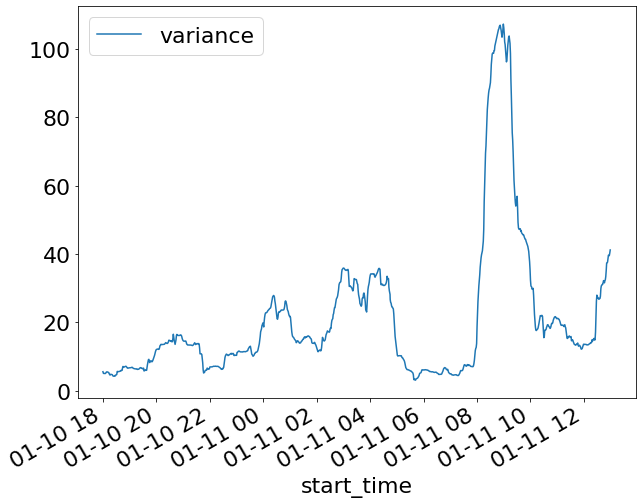

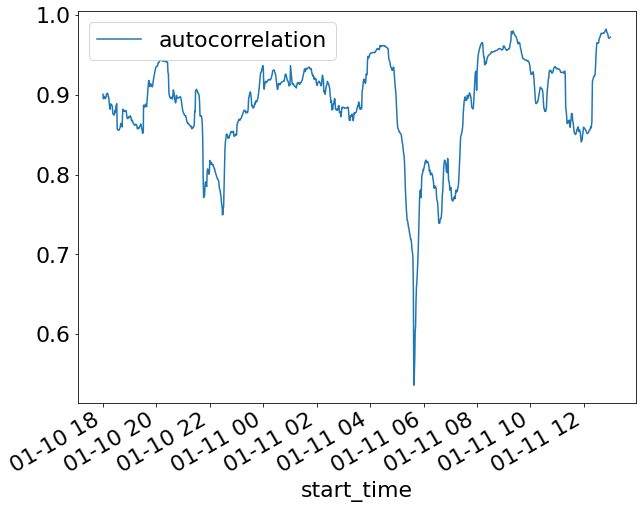

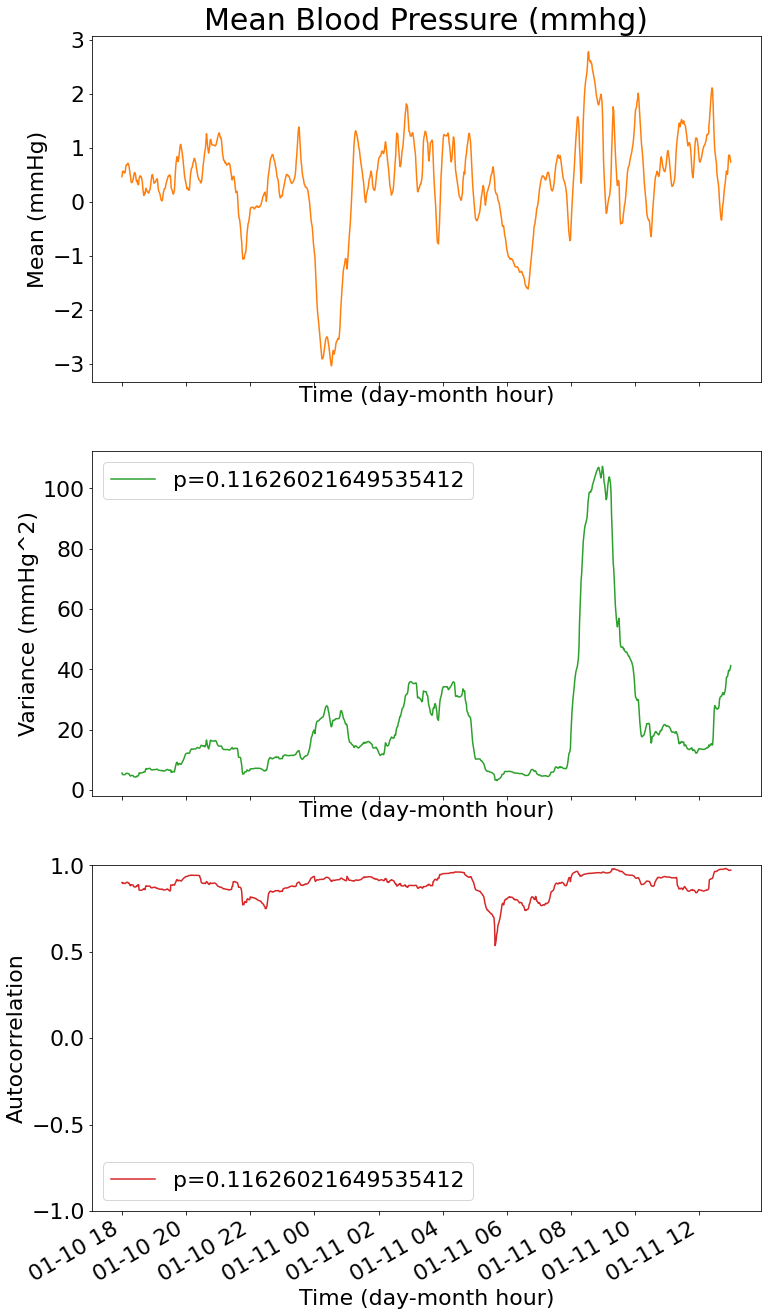

In [86]:
graph_grid2(PC_0192_ABF_m_residuals_no_anomalies, 60)